|  |  |
| ---: | :--- |
| Дата: | 22.10.2021 |
| Выполнил:| Волонцевич Олег |
| Тел. / WhatsApp / Telegram: | +7 (915) 254-31-96 |
| e-mail: | arkadamarket@mail.ru |


# Тестовое задание Lightmap

1  [Задание №1](#1)

2  [Задание №2](#2)  

3  [Задание №3](#3)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from datetime import datetime

from sklearn.linear_model import LinearRegression

<a name="1"></a>
## Задание №1
В специальной лотерее игрок выбирает 5 разных чисел из возможных 30. В этот же день случайным образом определяется победная комбинация из 7 разных чисел (из того же набора). Игрок считается победителем в случае, если совпадают любые 4 числа в выбранном им наборе и в победной комбинации.

**Какова вероятность выигрыша?**

 В общем случае задача решается по формуле гипергеометрической вероятности [(ссылка)](https://www.matburo.ru/tvart_sub.php?p=calc_gg_ball), но с формулами связываться не хочется - посчитаю "в лоб".

Победа будет засчитана в следующих случаях:
* все пять выбранных чисел входят в 7 победных 
* 4 выбранных числа входят в 7 победных, а 1 не входит

In [2]:
#Вероятность угадать все 5
p5 = (7/30)*(6/29)*(5/28)*(4/27)*(3/26)
p5

0.00014736221632773356

In [3]:
#Вероятность угадать 4
p4 = (7/30)*(6/29)*(5/28)*(4/27)*(23/26)*5 #на 5 домножаем т.к. неугаданное число может стоять на любом месте
p4

0.005648884959229786

In [4]:
print('вероятность выигрыша:', p5+p4)

вероятность выигрыша: 0.005796247175557519


**Вывод:**
Вероятность выигрыша чуть больше чем пол процента.

<a name="2"></a>
## Задание №2
В файле "Lightmap. Тестовое задание №2.csv" построчно приведены записи событий установки приложения (install) и начала сессии (login). В столбце player_id указан уникальный id пользователя, в столбце event_timestamp - время события (unix timestamp UTC). 

Удержание первого дня определяется как доля уникальных пользователей, отправивших событие login на следующий календарный день, среди всех пользователей, отправивших событие install в текущий календарный день. Например, если 1 сентября 100 пользователей скачали приложение, и 50 из них совершили логин 2 сентября, удержание первого дня для 1 сентября составляет 50%.

Удержание первого дня для периода дат определяется как отношение общего числа уникальных пользователей, вернувшихся в приложение на следующий день после дня установки, к общему числу уникальных пользователей, совершивших установку в рамках заданного периода дат.

*Например, если 2 сентября 200 пользователей скачали приложение, и 75 из них совершили логин 3 сентября, удержание первого дня за период 1-2 сентября составляет: (50 + 75) / (100 + 200) ≈ 42%*

**Можно ли с уверенностью утверждать, что удержание первого дня за период с 15 по 18 сентября выше, чем удержание первого дня за период с 19 по 22 сентября? И почему?**

In [5]:
data_2 = pd.read_csv('Lightmap. Тестовое задание №2.csv')
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52543 entries, 0 to 52542
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   player_id        52543 non-null  int64 
 1   event_timestamp  52543 non-null  int64 
 2   event_name       52543 non-null  object
dtypes: int64(2), object(1)
memory usage: 1.2+ MB


In [6]:
data_2['event_timestamp'] = pd.to_datetime(data_2['event_timestamp'], unit='s')
display(data_2.head(3))
print('минимальное время:', data_2['event_timestamp'].min())
print('максимальное время:', data_2['event_timestamp'].max())

,player_id,event_timestamp,event_name
0,1058930,2021-09-21 23:08:53,install
1,1055681,2021-09-23 15:55:26,login
2,1057784,2021-09-23 15:42:55,login


минимальное время: 2021-09-15 00:00:13
максимальное время: 2021-09-23 23:59:53


**Промежуточный вывод:**

Время события указано в формате UTC. Для пользователей нет данных о часовых поясах.
Таким образом можно воспользоваться одной из двух стратегий:
* использовать дату по времени UTC
* считать целевым входом событие в интервале от 24 до 48 часов от времени установки.

Исходя из формулировки и данных реализуем первый вариант.

Вместо даты оставим только число.

In [7]:
data_2['event_timestamp'] = data_2['event_timestamp'].dt.day

In [8]:
display(data_2.head(3))

,player_id,event_timestamp,event_name
0,1058930,21,install
1,1055681,23,login
2,1057784,23,login


In [9]:
retention_dict = {} #словарь для значений по дням
for i in (15, 16, 17, 18, 19, 20, 21, 22):
    day_dict={} #словарь для подсчета уникальных install и возвратов за день
    install = data_2[data_2['event_timestamp'] == i].query("event_name == 'install'")
    day_dict['install_count'] = install['player_id'].count()
    login = data_2[data_2['event_timestamp'] == i+1].query("event_name == 'login'")
    retention = install.merge(login, on='player_id', how='inner')
    day_dict['retention_count'] = retention['player_id'].nunique()
    day_dict['retention'] = day_dict['retention_count'] / day_dict['install_count']
    retention_dict[i] = day_dict
retention_df = pd.DataFrame(retention_dict).T
display(retention_df)

,install_count,retention_count,retention
15,1327.0,428.0,0.322532
16,1284.0,398.0,0.309969
17,1483.0,495.0,0.333783
18,1779.0,566.0,0.318156
19,1674.0,509.0,0.304062
20,1380.0,404.0,0.292754
21,2123.0,523.0,0.246350
22,1343.0,358.0,0.266567


In [10]:
retention15_18 = retention_df[retention_df.index < 19]['retention_count'].sum() / retention_df[
                                retention_df.index < 19]['install_count'].sum()
retention19_22 = retention_df[retention_df.index >= 19]['retention_count'].sum() / retention_df[
                                retention_df.index >= 19]['install_count'].sum()
print('удержание первого дня за период с 15 по 18 сентября', retention15_18)
print('удержание первого дня за период с 19 по 22 сентября', retention19_22)

удержание первого дня за период с 15 по 18 сентября 0.32130086838072536
удержание первого дня за период с 19 по 22 сентября 0.27515337423312886


**Вывод:** 

Используя дату по UTC можно утверждать что удержание первого дня за период с 15 по 18 сентября (≈32%) выше, чем удержание первого дня за период с 19 по 22 сентября (≈28%). 

Однако отсутствие данных о часовом поясе пользователя может вносить шум (регистрация и вход по UTC попадает на одну дату а по региональному времени относится к разным или наоборот).

<a name="3"></a>
## Задание №3
В файле "Lightmap. Тестовое задание №3.csv" построчно приведены записи транзакций, совершенных в приложении когортой пользователей. В столбце event_timestamp указано время транзакции (unix timestamp UTC), в столбце registration_timestamp - дата регистрации пользователя, в столбце inapp_size - размер соответствующего платежа (сумма $).

**Требуется построить кривую накопительной суммы платежей когорты по дням с момента регистрации (один день - одна точка на кривой). На основании полученных данных построить и отобразить в виде другой кривой на том же графике прогноз значений накопительной суммы для дней жизни с 90 по 180.**

Вероятно задача расчитана на решение в Excel, но попробую в Python.

In [11]:
data_3 = pd.read_csv('Lightmap. Тестовое задание №3.csv')
data_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11577 entries, 0 to 11576
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   event_timestamp         11577 non-null  int64
 1   registration_timestamp  11577 non-null  int64
 2   inapp_size              11577 non-null  int64
dtypes: int64(3)
memory usage: 271.5 KB


In [12]:
data_3['event_timestamp'] = pd.to_datetime(data_3['event_timestamp'], unit='s')
data_3['registration_timestamp'] = pd.to_datetime(data_3['registration_timestamp'], unit='s')
display(data_3.head(15))
print('минимальное время транзакции:', data_3['event_timestamp'].min())
print('максимальное время транзакции:', data_3['event_timestamp'].max())
print('минимальное время регистрации:', data_3['registration_timestamp'].min())
print('максимальное время регистрации:', data_3['registration_timestamp'].max())

,event_timestamp,registration_timestamp,inapp_size
0,2021-01-20 14:47:18,2021-01-18 12:02:39,5
1,2021-01-27 15:04:58,2021-01-18 12:22:02,3
2,2021-01-19 11:59:54,2021-01-18 12:55:45,5
3,2021-01-25 08:15:55,2021-01-18 13:24:11,3
4,2021-01-19 18:51:30,2021-01-18 13:27:41,3
5,2021-01-19 18:54:55,2021-01-18 13:27:41,3
6,2021-01-20 14:29:53,2021-01-18 13:27:41,3
7,2021-01-25 18:56:43,2021-01-18 13:27:41,1
8,2021-01-18 13:50:13,2021-01-18 13:27:41,5
9,2021-01-23 16:05:25,2021-01-18 13:27:41,3


минимальное время транзакции: 2021-01-01 00:38:24
максимальное время транзакции: 2021-04-29 19:00:45
минимальное время регистрации: 2021-01-01 00:00:04
максимальное время регистрации: 2021-01-31 23:40:00


В файле данные по транзакциям пользователей с датой регистрации в январе 2021г.

In [13]:
data_3['days'] = (data_3['event_timestamp'] - data_3['registration_timestamp']).dt.days
data_3

,event_timestamp,registration_timestamp,inapp_size,days
0,2021-01-20 14:47:18,2021-01-18 12:02:39,5,2
1,2021-01-27 15:04:58,2021-01-18 12:22:02,3,9
2,2021-01-19 11:59:54,2021-01-18 12:55:45,5,0
3,2021-01-25 08:15:55,2021-01-18 13:24:11,3,6
4,2021-01-19 18:51:30,2021-01-18 13:27:41,3,1
...,...,...,...,...
11572,2021-01-25 06:32:56,2021-01-18 11:41:30,3,6
11573,2021-01-25 06:31:50,2021-01-18 11:41:30,3,6
11574,2021-01-25 16:42:59,2021-01-18 11:41:30,1,7
11575,2021-01-20 04:25:08,2021-01-18 11:48:57,3,1


In [14]:
day_inapp = data_3.groupby('days').agg({'inapp_size': ['count', 'sum']})
day_inapp.index.name = None
day_inapp.columns = ['inapp_count', 'inapp_sum']
day_inapp['inapp_cumsum'] = day_inapp['inapp_sum'].cumsum()
day_inapp['day'] = day_inapp.index
day_inapp
#data_3.info()       df["revenue_cum"] = df["revenue"].cumsum()

,inapp_count,inapp_sum,inapp_cumsum,day
0,2573,22612,22612,0
1,925,5256,27868,1
2,697,3519,31387,2
3,506,3644,35031,3
4,410,2613,37644,4
...,...,...,...,...
85,53,301,80529,85
86,40,513,81042,86
87,28,206,81248,87
88,50,392,81640,88


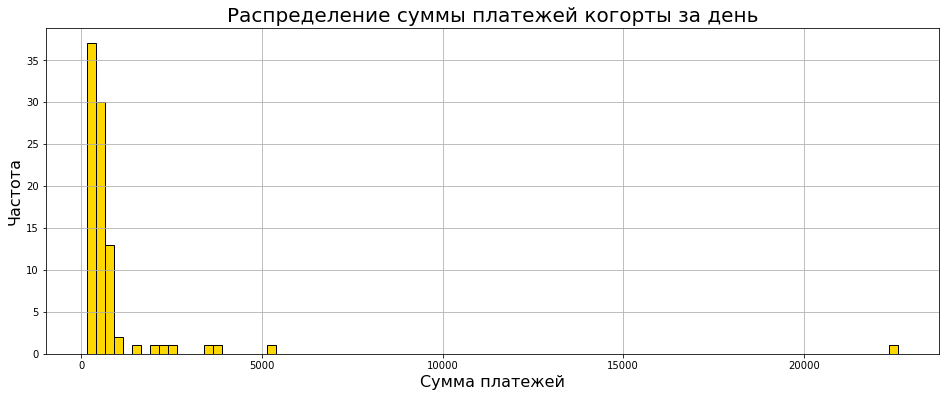

In [15]:
day_inapp['inapp_sum'].plot.hist(bins=90, edgecolor = 'black', figsize=(16, 6), grid=True, color='gold')
plt.title('Распределение суммы платежей когорты за день', fontsize=20)
plt.ylabel('Частота', fontsize=16)
plt.xlabel('Сумма платежей', fontsize=16);

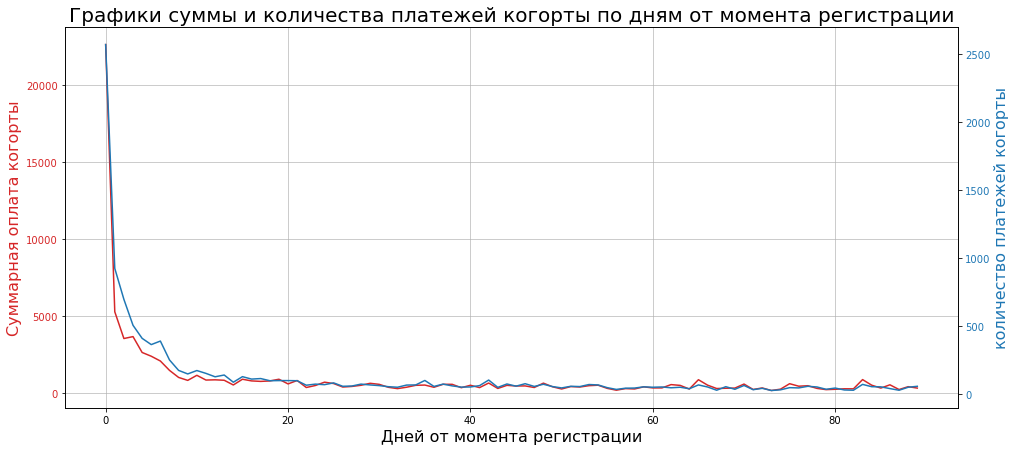

In [16]:
x = day_inapp.index
y1 = day_inapp['inapp_sum']
y2 = day_inapp['inapp_count']

# сумма платежей когорты в день
fig, ax1 = plt.subplots(1,1,figsize=(16,7)) #dpi= 80
ax1.plot(x, y1, color='tab:red')

ax1.set_xlabel('Дней от момента регистрации', fontsize=16)
ax1.set_ylabel('Суммарная оплата когорты', color='tab:red', fontsize=16)
ax1.tick_params(axis='y', rotation=0, labelcolor='tab:red' )
ax1.grid(alpha=.8)

# количество платежей
ax2 = ax1.twinx()
ax2.plot(x, y2, color='tab:blue')

ax2.set_ylabel('количество платежей когорты', color='tab:blue', fontsize=16)
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.set_title('Графики суммы и количества платежей когорты по дням от момента регистрации', fontsize=20);

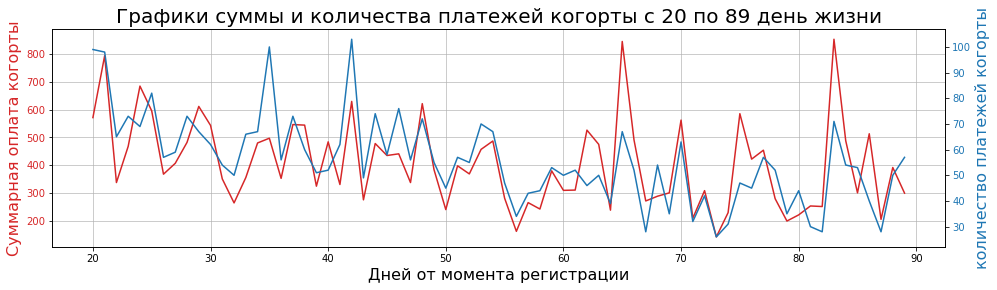

In [17]:
x = day_inapp.index[20:90]
y1 = day_inapp[20:90]['inapp_sum']
y2 = day_inapp[20:90]['inapp_count']

# сумма платежей когорты в день
fig, ax1 = plt.subplots(1,1,figsize=(16,4)) #dpi= 80
ax1.plot(x, y1, color='tab:red')

ax1.set_xlabel('Дней от момента регистрации', fontsize=16)
ax1.set_ylabel('Суммарная оплата когорты', color='tab:red', fontsize=16)
ax1.tick_params(axis='y', rotation=0, labelcolor='tab:red' )
ax1.grid(alpha=.8)

# количество платежей
ax2 = ax1.twinx()
ax2.plot(x, y2, color='tab:blue')

ax2.set_ylabel('количество платежей когорты', color='tab:blue', fontsize=16)
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.set_title('Графики суммы и количества платежей когорты с 20 по 89 день жизни', fontsize=20);

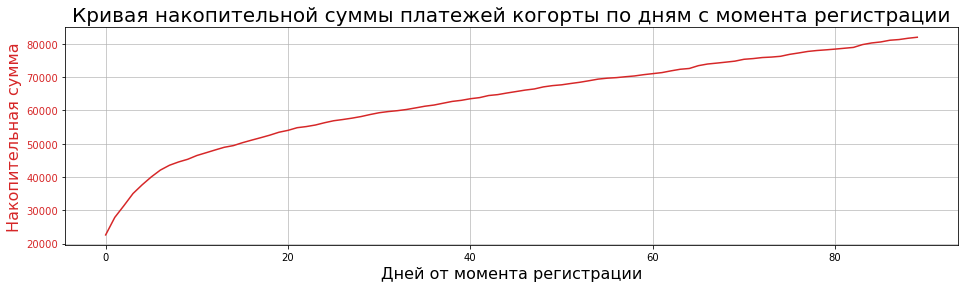

In [18]:
x = day_inapp.index
y1 = day_inapp['inapp_cumsum']
#y2 = day_inapp['inapp_count']

# сумма платежей когорты в день
fig, ax1 = plt.subplots(1,1,figsize=(16,4)) #dpi= 80
ax1.plot(x, y1, color='tab:red')

ax1.set_xlabel('Дней от момента регистрации', fontsize=16)
ax1.set_ylabel('Накопительная сумма', color='tab:red', fontsize=16)
ax1.tick_params(axis='y', rotation=0, labelcolor='tab:red' )
ax1.grid(alpha=.8)
ax1.set_title('Кривая накопительной суммы платежей когорты по дням с момента регистрации', fontsize=20)

# количество платежей
#ax2 = ax1.twinx()
#ax2.plot(x, y2, color='tab:blue')

ax2.set_ylabel('количество платежей когорты', color='tab:blue', fontsize=16)
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.set_title('кривую накопительной суммы платежей когорты по дням с момента регистрации', fontsize=20);

Посмотрим на "скользящее среднее".

In [19]:
day_inapp['rolling_mean'] = day_inapp['inapp_sum'].shift().rolling(14).mean()

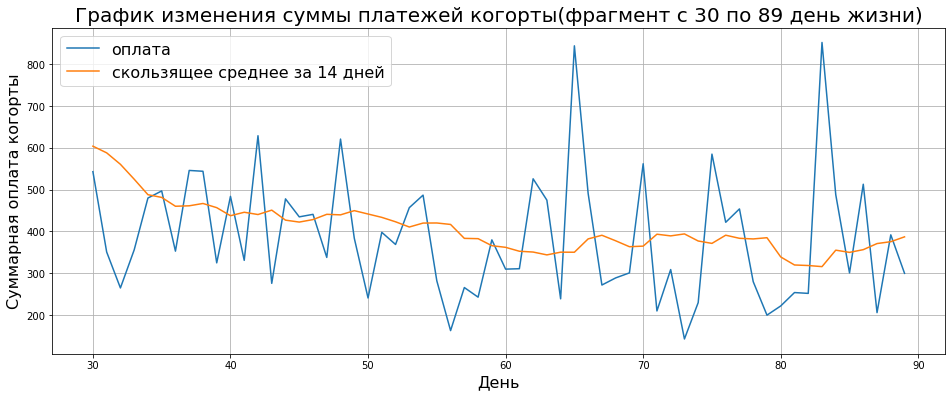

In [20]:
day_inapp.loc[30:90, ['inapp_sum', 'rolling_mean']].plot(figsize=(16, 6), grid=True)
plt.title('График изменения суммы платежей когорты(фрагмент с 30 по 89 день жизни)', fontsize=20) 
plt.ylabel('Суммарная оплата когорты', fontsize=16)
plt.xlabel('День', fontsize=16)
plt.legend(['оплата', 'скользящее среднее за 14 дней'], fontsize=16)
ax1.grid(alpha=.8);

Ряд имеет тренд на снижение суммарной оплаты. сезонность не прослеживается.
Логично предсказать прямой с учетом тренда исключив высокие значения и разброс на старте.

In [21]:
for i in range(90,180):
    day_inapp.loc[i, 'day'] = i
day_inapp

,inapp_count,inapp_sum,inapp_cumsum,day,rolling_mean
0,2573.0,22612.0,22612.0,0.0,NaN
1,925.0,5256.0,27868.0,1.0,NaN
2,697.0,3519.0,31387.0,2.0,NaN
3,506.0,3644.0,35031.0,3.0,NaN
4,410.0,2613.0,37644.0,4.0,NaN
...,...,...,...,...,...
175,NaN,NaN,NaN,175.0,NaN
176,NaN,NaN,NaN,176.0,NaN
177,NaN,NaN,NaN,177.0,NaN
178,NaN,NaN,NaN,178.0,NaN


In [22]:
features_train = day_inapp.query('day<90 & day>30')['day'].values.reshape(-1, 1)
target_train = day_inapp.query('day<90 & day>30')['inapp_sum'].values
features_test = day_inapp.query('day>=90')['day'].values.reshape(-1, 1)

**Линейная регрессия**

In [23]:
model_1 = LinearRegression()

model_1.fit(features_train, target_train)
#model_1.rmse = mean_squared_error(target_test, model_1.predict(features_test))**0.5
model_1.name = 'LinearRegression'

pred = model_1.predict(features_test)


**Важно!**
Так как сумма поступающих платежей не может быть отрицательной, а прогноз линейно убывает - отрицательные значения необходимо обнулить. 

In [24]:
pred = np.where(pred < 0, 0, pred)

In [25]:
for i in range(90,180):
    day_inapp.loc[i, 'inapp_sum_pred'] = pred[i-90]
day_inapp['inapp_cumsum_pred'] = day_inapp['inapp_sum_pred'].cumsum() + day_inapp.loc[89, 'inapp_cumsum']
day_inapp[85:95]

,inapp_count,inapp_sum,inapp_cumsum,day,rolling_mean,inapp_sum_pred,inapp_cumsum_pred
85,53.0,301.0,80529.0,85.0,350.071429,NaN,NaN
86,40.0,513.0,81042.0,86.0,356.571429,NaN,NaN
87,28.0,206.0,81248.0,87.0,371.142857,NaN,NaN
88,50.0,392.0,81640.0,88.0,375.642857,NaN,NaN
89,57.0,300.0,81940.0,89.0,387.214286,NaN,NaN
90,NaN,NaN,NaN,90.0,NaN,349.292227,82289.292227
91,NaN,NaN,NaN,91.0,NaN,348.136996,82637.429223
92,NaN,NaN,NaN,92.0,NaN,346.981765,82984.410988
93,NaN,NaN,NaN,93.0,NaN,345.826534,83330.237522
94,NaN,NaN,NaN,94.0,NaN,344.671303,83674.908825


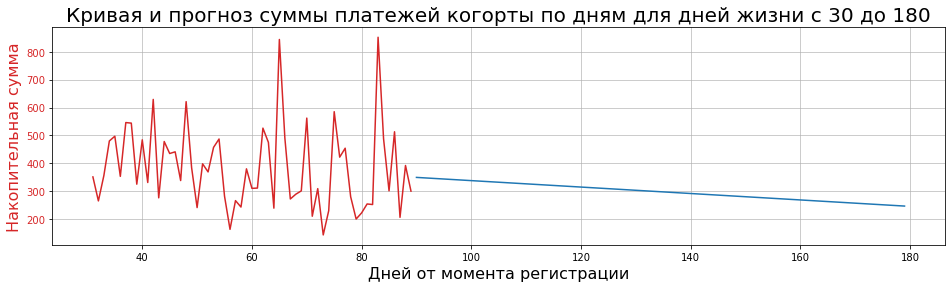

In [26]:
x = day_inapp.query('index>30').index
y1 = day_inapp.query('index>30')['inapp_sum']
y2 = day_inapp.query('index>30')['inapp_sum_pred']

# сумма платежей когорты в день
fig, ax1 = plt.subplots(1,1,figsize=(16,4))
ax1.plot(x, y1, color='tab:red')

ax1.set_xlabel('Дней от момента регистрации', fontsize=16)
ax1.set_ylabel('Накопительная сумма', color='tab:red', fontsize=16)
ax1.tick_params(axis='y', rotation=0, labelcolor='tab:red' )
ax1.grid(alpha=.8)
ax1.set_title('Кривая и прогноз суммы платежей когорты по дням для дней жизни с 30 до 180', fontsize=20)
ax1.plot(x, y2, color='tab:blue');

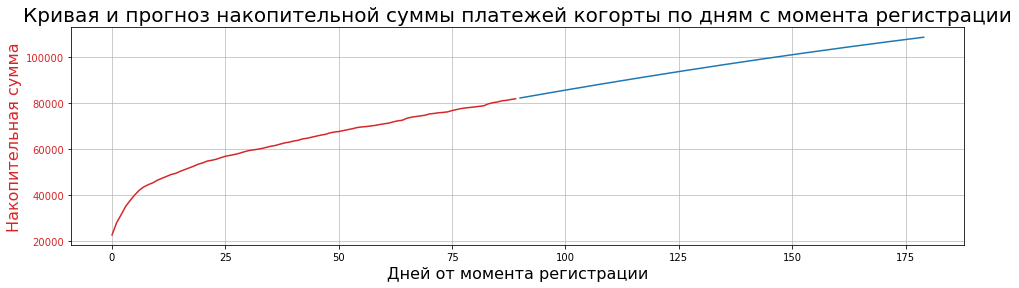

In [27]:
x = day_inapp.index
y1 = day_inapp['inapp_cumsum']
y2 = day_inapp['inapp_cumsum_pred']

# сумма платежей когорты в день
fig, ax1 = plt.subplots(1,1,figsize=(16,4))
ax1.plot(x, y1, color='tab:red')

ax1.set_xlabel('Дней от момента регистрации', fontsize=16)
ax1.set_ylabel('Накопительная сумма', color='tab:red', fontsize=16)
ax1.tick_params(axis='y', rotation=0, labelcolor='tab:red' )
ax1.grid(alpha=.8)
ax1.set_title('Кривая и прогноз накопительной суммы платежей когорты по дням с момента регистрации', fontsize=20)
ax1.plot(x, y2, color='tab:blue');

**Вывод:** 

Для решения данной задачи достаточно линейной регресии. Более серьезные возможности картину сильно не изменят.

В Excel многие вещи были бы быстрее - попробую и там выполнить.